
# Personalized Melanoma Staging Model

The goal of this project is to create an easily understood and used tool for doctors to predict whether patients need a sentinel lymph node biopsy (SLNB). SLNB are an invasive procedure and currently doctors suggest it to patients if there is around a 10% chance for a positive biopsy. These odds are mostly based upon the depth of the melanoma, so I would like to use more data in order to create better predictions for the odds that patients need the biopsy. 

# The Data
I am using data from two sources: the National Cancer Database and the NIH's SEER Database. These have been combined into a single PostgreSQL table for faster query access.

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import psycopg2 as sql

sql_mela = sql.connect(host="localhost", user="karenlarson", dbname="melanoma")
query = """SELECT "AGE", "SEX", "DEPTH", "ULCERATION", "MITOSES", "CS_EXTENSION", "PRIMARY_SITE", "CS_LYMPH_NODE_METS"
           FROM melanoma"""


#query = """SELECT "AGE", "SEX", "DEPTH", "ULCERATION", "MITOSES", "CS_EXTENSION", "PRIMARY_SITE", "CS_LYMPH_NODE_METS"
#            FROM melanoma
#                WHERE ("DEPTH" >= 80) OR ("DEPTH" < 80 AND "ULCERATION" >= 1)"""
 #           WHERE "DEPTH" < 80 AND "ULCERATION" = 0"""
#
##query for matching JCO data            
#query = """SELECT "AGE", "SEX", "DEPTH", "ULCERATION", "MITOSES", "CS_EXTENSION", "PRIMARY_SITE", "CS_LYMPH_NODE_METS"
#           FROM melanoma
#           WHERE ("DEPTH" <= 400 AND "DEPTH" >= 100)
#           OR (("DEPTH" < 100 AND "DEPTH" >= 75) AND
#           ("ULCERATION" >= 1 OR "MITOSES" >= 1 OR "AGE" < 40 )) OR 
#           (("DEPTH" < 75 AND "DEPTH" >= 54) AND 
#           (("MITOSES" >= 1 AND "ULCERATION" >= 1) OR ("ULCERATION" >= 1
#           AND "AGE" < 40) OR ("MITOSES" >= 1 AND "AGE" < 40)));"""

In [2]:
mela = pd.read_sql_query(query, sql_mela)

In [3]:
mela.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860205 entries, 0 to 860204
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   AGE                 860205 non-null  int64  
 1   SEX                 860205 non-null  int64  
 2   DEPTH               860201 non-null  float64
 3   ULCERATION          860202 non-null  float64
 4   MITOSES             854683 non-null  float64
 5   CS_EXTENSION        860202 non-null  float64
 6   PRIMARY_SITE        860205 non-null  object 
 7   CS_LYMPH_NODE_METS  860202 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 52.5+ MB


As we can see, we have 860205 patients with originally 126 features (or attributes). Since it is a database, not all of these attributes would be known before a SLNB would be suggested and others of them would be irrelevant to the need for a biopsy. For example, <code>PUF_FACILITY_ID</code> (or the facility where these data were recorded) likely doesn't influence a patient's need for a biopsy. Using the SQL query, I have reduced this down to 7 key features, enumerated below:

- <code>AGE</code>: The age of the patient
- <code>SEX</code>: The sex of the patient
- <code>CS_SITESPECIFIC_FACTOR_1</code>: The depth of the tumor. I renamed this feature <code>DEPTH</code> to be more easily interpable
- <code>CS_SITESPECIFIC_FACTOR_2</code>: The formation of an ulcer on the skin. I renamed this feature <code>ULCERATION</code> to be more easily interpable
- <code>CS_EXTENSION</code>: Indicates the extent of the spread of the melanoma.
- <code>CS_SITESPECIFIC_FACTOR_7</code>: Categories for the number of mitoses per square mm around a "hot spot". I renamed this feature to <code>MITOSES</code> for interprability.
- <code>PRIMARY_SITE</code>: The main site for the melanoma. The options are:
    - <code>C44.0</code>: Skin of lips, NOS
    - <code>C44.1</code>: Eyelid
    - <code>C44.2</code>: External Ear
    - <code>C44.3</code>: Skin of other and unspecified parts of face
    - <code>C44.4</code>: Skin of scalp and neck
    - <code>C44.5</code>: Skin of the trunk
    - <code>C44.6</code>: Skin of upper limb and shoulder
    - <code>C44.7</code>: Skin of lower limb and hip
    - <code>C44.8</code>: Overlapping lesion of skin
    - <code>C44.9</code>: Skin, NOS
 
We are trying to calssify the patients into whether they had a positive lymph node biopsy or not. This is recorded in <code>CS_SITESPECIFIC_FACTOR_3</code>, here renamed as <code>CS_LYMPH_NODE_METS</code>.

# Data Cleaning

Some of the rows of the features are missing data and we also have a large number of medical codes that we want to reinterpret to make easier comparisons. This data cleaning is done using the <code>cleanData()</code> function. I used [this website](http://web2.facs.org/cstage0205/melanomaskin/MelanomaSkinschema.html) to understand the various medical encodings. The following steps are done for the data cleaning:

- I drop missing values (coded as 999, 1022, and NAN)
- I only look at melanoma coded as 1 <= <code>DEPTH</code> <= 980. Values recorded as 989 are relabeled as 980 (as they both encode tumors of size 9.80 mm or larger), and the other data labels are indicative of missing data. If the <code>DEPTH</code> is coded as 0, that means that no tumor mass was found, so those points are also excluded from consideration.
- I reincoded 990 as 0 and 991 as 1, as both of them represent a mitotic count (<code>MITOSES</code>), but are not specific in the exact mitotic rate. After, we only keep mitotic counts <= 11, as all other encodings represent missing data.
- For <code>ULCERATION</code>, I map 010 -> 001, as both of them represent that ulceration is present under the previous and current naming scheme. Then we only keep values equal to 1 or 0, as any other values represent missing data.
- <code>CS_EXTENSION</code> has data for both the Clark Level and for the staging information. The staging information is essentially already encoded in the <code>DEPTH</code> and <code>ULCERATION</code>, so we only want to focus on the Clark Level part (i.e. what level of the dermis has been invaded). We replace the codings that are not about the Clark Level with 999 and only keep the features that specify the Clark Level.
- <code>PRIMARY_SITE</code>, as mentioned above, encodes wehre the melanoma is located. I bin this into three categories: head (C44.0 - C44.4), trunk (C44.5), and limbs (C44.6 and C44.7). Since C44.8 and C44.9 do not give specific locations, these are dropped from consideration.
- <code>CS_LYMPH_NODE_METS</code> represents if the biopsy was positive or negative. The biopsy is only done if the lymph node metastasis is clinically occult (microscopic). The encodings that represent this are 000 and 005 for a negative biopsy and 001 and 010 for a positive biopsy. First, I recode 005 as 000 and 010 as 001, then I drop anything that has a value greater than 1.5.
- <code>SEX</code> and <code>AGE</code> did not have any missing data encodings, although patients 90 or older were binned into a single category.

After removing the missing data, we have a total of 194010 patients.

In [4]:
from cleanData import cleanData
X, y = cleanData(mela)

# Preparing Data for Training the Model

## Train/Validation/Test Split

I split the data into 70/10/20 Train/Valdiation/Test splits. We do this statified, as the data is skewed towards the negative class.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y,random_state=20)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.125, stratify = y_train, random_state=20)

## Encoding the Attributes

I treat <code>SEX</code>, <code>ULCERATION</code>, and <code>PRIMARY_SITE</code> as categorical attributes. 

For the numeric attributes, I first apply a <code>MinMaxScaler</code> in order to have them all on approximately the same order. Next, I use <code>PolynomialFeatures</code> of flexible degree. I initially wanted to use polynomial features, because I though that something like melanoma volume could be an important feature, and looking at <code>DEPTH</code>^3 could be an approximation for the volume. Plus, there may be some very interesting unseen relationships between the various parameters that using simple linear regression would not notice.

The exact attribute encoding pipeline is included in "encodeAttribs.py".

I only fit the pipeline on <code>X_train</code> in order to avoid data leakage by training it on the entire set.

In [13]:
from encodeAttribs import preprocess_pipeline

num_attribs = ['AGE','DEPTH', "CS_EXTENSION", "MITOSES",'ULCERATION']
cat_attribs = [ 'SEX','PRIMARY_SITE']

pipe = preprocess_pipeline(num_attribs, 3, cat_attribs).fit(X_train)
x_train = pipe.transform(X_train)
x_cv = pipe.transform(X_cv)
x_test = pipe.transform(X_test)

# Model Evaluation (and Comparison)

The main model considered is logistic regression, but here are some other model comparisons that I considered as comparison to see if we could gain any additional gains from more complex models.

I wanted to work with logistic regression as it is highly interpretable and can be easily retrained if new data becomes available.

## Base Estimator
The Baseline is the current standard: all of the patients considered had a biopsy, but only a fraction of them had a positive biopsy. Here, my baseLine model predicts that every patient should have a biopsy, and achieves and accuracy of about 6.5%.

In [7]:
from baseLine import BaseLine
from sklearn.model_selection import cross_val_score
base_line_clf = BaseLine()
base_scores = cross_val_score(base_line_clf,x_train,y_train,cv=10,scoring="accuracy")
print(base_scores.mean())

0.06495988070919924


However, the main metrics that I care about are recall and specificity for this type of problem. I care about recall because we want as many patients who have sentinel lymph node metastasis to get tested for it. On the other hand, we also want to ensure that people who do not require a SLNB are not getting it. Specificity gives us a measure of this.

For the current method used by doctors (e.g. suggesting treatment when patients are at various cancer stages), the recall is 1.00, and the specificity is 0.00 for the data I'm considering.

## Logistic Regression

I want to make sure we are using the right level of regularization, so I am doing a search over many of the regularization parameters and picking the ones that provide the best results on the validation data set.

RESULTS FOR REGULARIZATION 1e-05
66922
68885
135807


/Users/karenlarson/Desktop/MelaSentinel/MelanomaSentinel/classifierEvaluation.py:86: RuntimeWarning: invalid value encountered in long_scalars
  neg_predictive_value = tn/(tn + fn)


For the THRESHOLD 0.05, the negative predictive value is nan, the positive predictive value is 0.0080, the auc is 0.4075
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is nan, the positive predictive value is 0.0081, the auc is 0.4043


/Users/karenlarson/Desktop/MelaSentinel/MelanomaSentinel/classifierEvaluation.py:86: RuntimeWarning: invalid value encountered in long_scalars
  neg_predictive_value = tn/(tn + fn)


For the Training Data using Logistic Regression, the accuracy is 0.0650, the precision is 0.0650, the recall is 1.0000, the specificity is 0.0000, the f1 score is 0.1220, the auc is 0.4075
[[     0 126985]
 [     0   8822]]


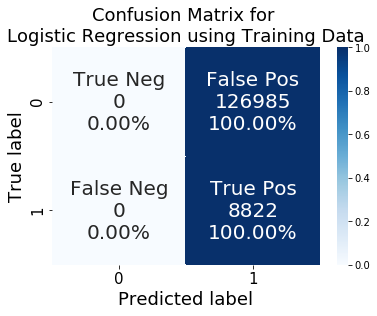

For the Validation Data using Logistic Regression, the accuracy is 0.0649, the precision is 0.0649, the recall is 1.0000, the specificity is 0.0000, the f1 score is 0.1220, the auc is 0.4043
[[    0 18141]
 [    0  1260]]


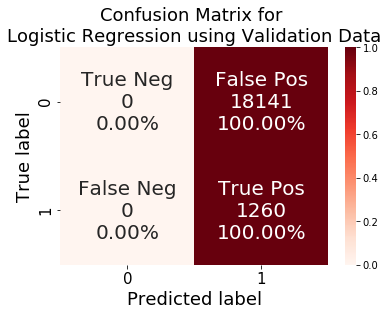





RESULTS FOR REGULARIZATION 0.0005
66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9597, the positive predictive value is 0.0100, the auc is 0.7691
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9601, the positive predictive value is 0.0105, the auc is 0.7673
For the Training Data using Logistic Regression, the accuracy is 0.2952, the precision is 0.0804, the recall is 0.9441, the specificity is 0.2501, the f1 score is 0.1482, the auc is 0.7691
[[31764 95221]
 [  493  8329]]


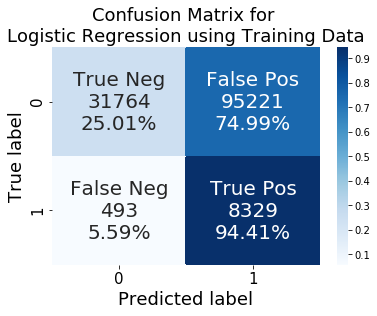

For the Validation Data using Logistic Regression, the accuracy is 0.2964, the precision is 0.0806, the recall is 0.9452, the specificity is 0.2514, the f1 score is 0.1486, the auc is 0.7673
[[ 4560 13581]
 [   69  1191]]


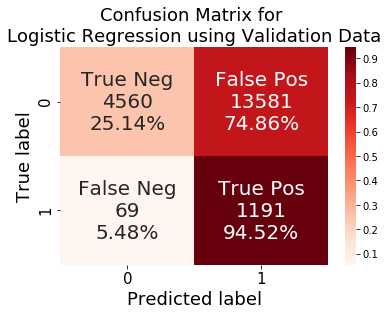





RESULTS FOR REGULARIZATION 0.0001
66922
68885
135807


/Users/karenlarson/Desktop/MelaSentinel/MelanomaSentinel/classifierEvaluation.py:86: RuntimeWarning: invalid value encountered in long_scalars
  neg_predictive_value = tn/(tn + fn)


For the THRESHOLD 0.05, the negative predictive value is nan, the positive predictive value is 0.0080, the auc is 0.6922
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is nan, the positive predictive value is 0.0081, the auc is 0.6926


/Users/karenlarson/Desktop/MelaSentinel/MelanomaSentinel/classifierEvaluation.py:86: RuntimeWarning: invalid value encountered in long_scalars
  neg_predictive_value = tn/(tn + fn)


For the Training Data using Logistic Regression, the accuracy is 0.0650, the precision is 0.0650, the recall is 1.0000, the specificity is 0.0000, the f1 score is 0.1220, the auc is 0.6922
[[     0 126985]
 [     0   8822]]


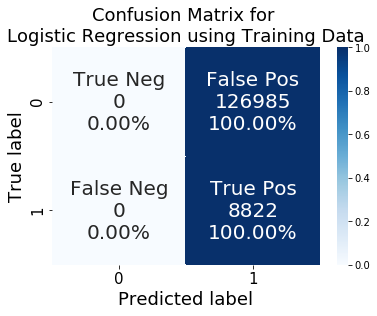

For the Validation Data using Logistic Regression, the accuracy is 0.0649, the precision is 0.0649, the recall is 1.0000, the specificity is 0.0000, the f1 score is 0.1220, the auc is 0.6926
[[    0 18141]
 [    0  1260]]


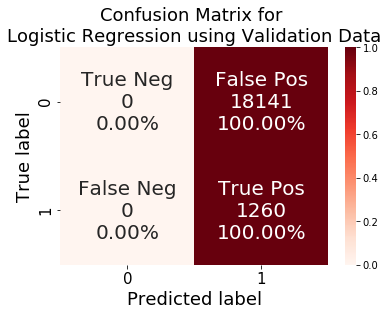





RESULTS FOR REGULARIZATION 0.005
66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9563, the positive predictive value is 0.0258, the auc is 0.8234
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9583, the positive predictive value is 0.0252, the auc is 0.8221
For the Training Data using Logistic Regression, the accuracy is 0.6376, the precision is 0.1367, the recall is 0.8610, the specificity is 0.6221, the f1 score is 0.2359, the auc is 0.8234
[[78998 47987]
 [ 1226  7596]]


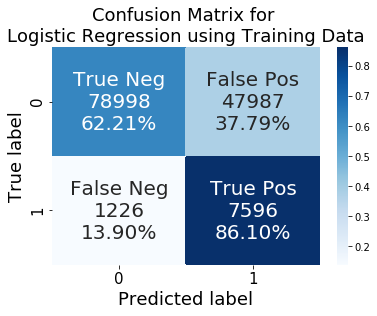

For the Validation Data using Logistic Regression, the accuracy is 0.6419, the precision is 0.1382, the recall is 0.8619, the specificity is 0.6266, the f1 score is 0.2382, the auc is 0.8221
[[11367  6774]
 [  174  1086]]


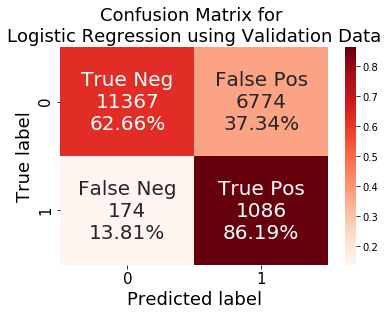





RESULTS FOR REGULARIZATION 0.001
66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9538, the positive predictive value is 0.0130, the auc is 0.7894
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9552, the positive predictive value is 0.0139, the auc is 0.7878
For the Training Data using Logistic Regression, the accuracy is 0.4586, the precision is 0.0982, the recall is 0.8966, the specificity is 0.4282, the f1 score is 0.1771, the auc is 0.7894
[[54371 72614]
 [  912  7910]]


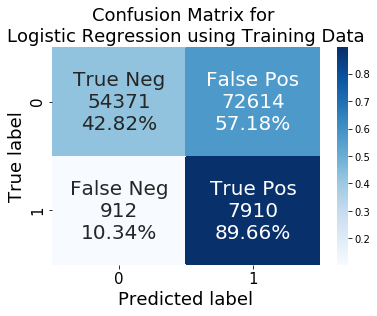

For the Validation Data using Logistic Regression, the accuracy is 0.4636, the precision is 0.0992, the recall is 0.8984, the specificity is 0.4334, the f1 score is 0.1787, the auc is 0.7878
[[ 7862 10279]
 [  128  1132]]


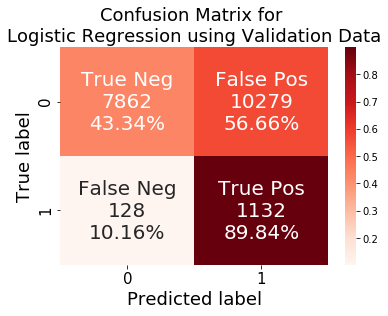





RESULTS FOR REGULARIZATION 0.05
66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9602, the positive predictive value is 0.0509, the auc is 0.8440
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9639, the positive predictive value is 0.0551, the auc is 0.8418
For the Training Data using Logistic Regression, the accuracy is 0.6879, the precision is 0.1558, the recall is 0.8607, the specificity is 0.6759, the f1 score is 0.2638, the auc is 0.8440
[[85832 41153]
 [ 1229  7593]]


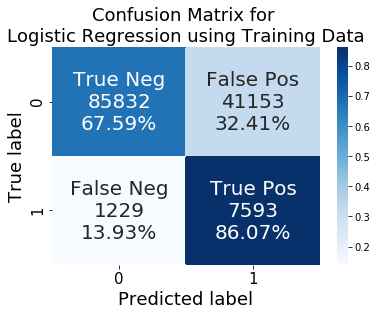

For the Validation Data using Logistic Regression, the accuracy is 0.6905, the precision is 0.1580, the recall is 0.8698, the specificity is 0.6780, the f1 score is 0.2674, the auc is 0.8418
[[12300  5841]
 [  164  1096]]


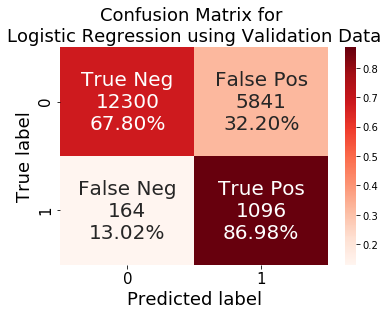





RESULTS FOR REGULARIZATION 0.01
66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9569, the positive predictive value is 0.0359, the auc is 0.8326
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9594, the positive predictive value is 0.0390, the auc is 0.8310
For the Training Data using Logistic Regression, the accuracy is 0.6668, the precision is 0.1467, the recall is 0.8572, the specificity is 0.6536, the f1 score is 0.2505, the auc is 0.8326
[[83000 43985]
 [ 1260  7562]]


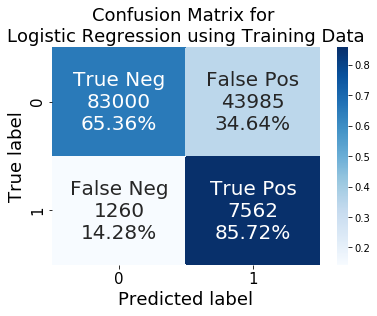

For the Validation Data using Logistic Regression, the accuracy is 0.6708, the precision is 0.1489, the recall is 0.8627, the specificity is 0.6575, the f1 score is 0.2539, the auc is 0.8310
[[11927  6214]
 [  173  1087]]


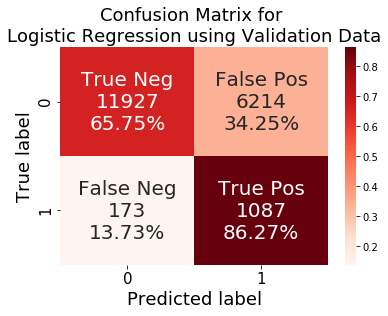





RESULTS FOR REGULARIZATION 0.5
66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9642, the positive predictive value is 0.0605, the auc is 0.8501
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9655, the positive predictive value is 0.0734, the auc is 0.8477
For the Training Data using Logistic Regression, the accuracy is 0.6893, the precision is 0.1578, the recall is 0.8723, the specificity is 0.6766, the f1 score is 0.2673, the auc is 0.8501
[[85916 41069]
 [ 1127  7695]]


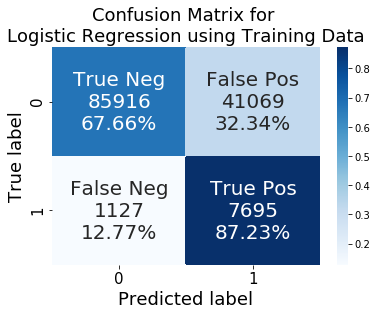

For the Validation Data using Logistic Regression, the accuracy is 0.6918, the precision is 0.1595, the recall is 0.8770, the specificity is 0.6789, the f1 score is 0.2698, the auc is 0.8477
[[12316  5825]
 [  155  1105]]


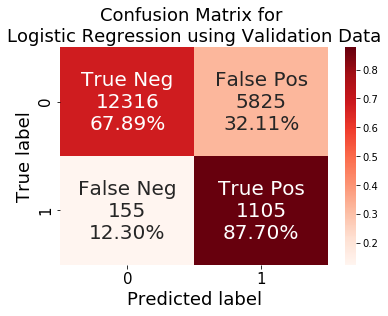





RESULTS FOR REGULARIZATION 1
66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9650, the positive predictive value is 0.0599, the auc is 0.8513
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9652, the positive predictive value is 0.0716, the auc is 0.8490
For the Training Data using Logistic Regression, the accuracy is 0.6887, the precision is 0.1578, the recall is 0.8738, the specificity is 0.6759, the f1 score is 0.2673, the auc is 0.8513
[[85827 41158]
 [ 1113  7709]]


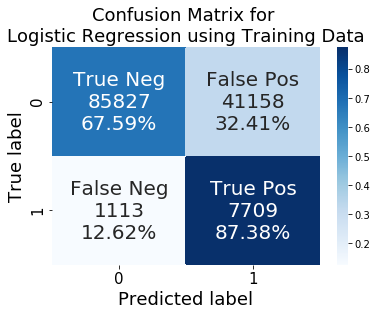

For the Validation Data using Logistic Regression, the accuracy is 0.6902, the precision is 0.1585, the recall is 0.8754, the specificity is 0.6773, the f1 score is 0.2685, the auc is 0.8490
[[12287  5854]
 [  157  1103]]


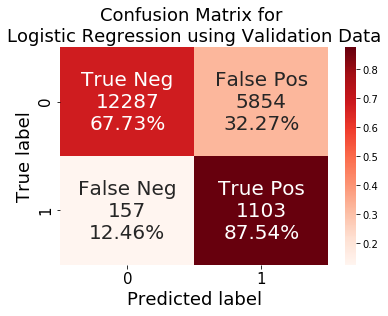





RESULTS FOR REGULARIZATION 5
66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9665, the positive predictive value is 0.0639, the auc is 0.8532
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9677, the positive predictive value is 0.0712, the auc is 0.8512
For the Training Data using Logistic Regression, the accuracy is 0.6885, the precision is 0.1581, the recall is 0.8776, the specificity is 0.6754, the f1 score is 0.2680, the auc is 0.8532
[[85765 41220]
 [ 1080  7742]]


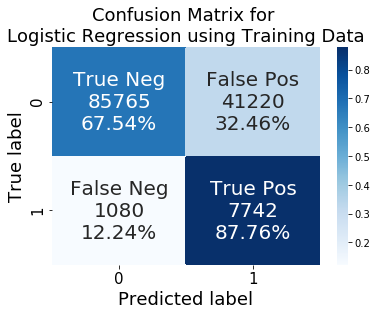

For the Validation Data using Logistic Regression, the accuracy is 0.6881, the precision is 0.1583, the recall is 0.8810, the specificity is 0.6747, the f1 score is 0.2684, the auc is 0.8512
[[12240  5901]
 [  150  1110]]


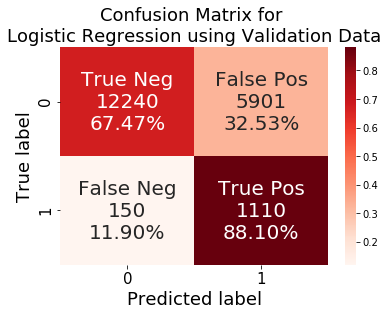





RESULTS FOR REGULARIZATION 10
66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9669, the positive predictive value is 0.0637, the auc is 0.8536
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9673, the positive predictive value is 0.0751, the auc is 0.8517
For the Training Data using Logistic Regression, the accuracy is 0.6883, the precision is 0.1581, the recall is 0.8784, the specificity is 0.6751, the f1 score is 0.2680, the auc is 0.8536
[[85724 41261]
 [ 1073  7749]]


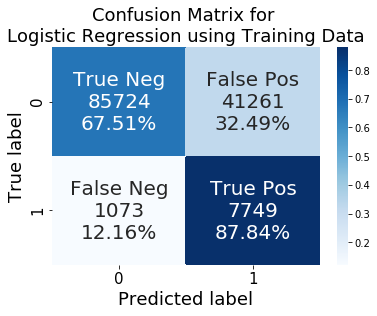

For the Validation Data using Logistic Regression, the accuracy is 0.6885, the precision is 0.1584, the recall is 0.8802, the specificity is 0.6752, the f1 score is 0.2685, the auc is 0.8517
[[12249  5892]
 [  151  1109]]


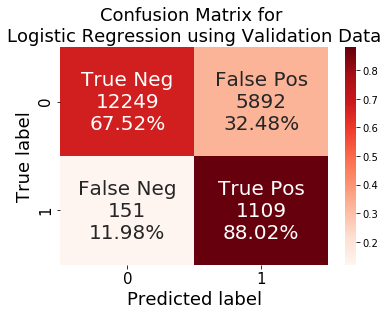

In [21]:
from sklearn.linear_model import LogisticRegression
from classifierEvaluation import classifierEvaluation
from classifierEvaluation import predictiveValue
regularization = [0.00001, 0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 1, 5, 10]
for reg in regularization:
    log_clf = LogisticRegression(solver="liblinear", fit_intercept=False, C = reg)
    log_clf.fit(x_train,y_train)
    print(f"RESULTS FOR REGULARIZATION {reg}")
    predictiveValue(log_clf, 0.05, X_train, y_train, pipe)
    predictiveValue(log_clf, 0.05, X_cv, y_cv, pipe)
    #predictiveValue(log_clf, 0.05, X_test, y_test, pipe)

    classifierEvaluation(log_clf, 0.05, x_train, y_train, "Logistic Regression", "Training Data")
    classifierEvaluation(log_clf, 0.05, x_cv, y_cv, "Logistic Regression", "Validation Data")
    print("\n\n\n")

Based on the above NPV and PPV for the T1b+s vs T1as, I am going to pick 1 for the regularization parameter. We have the resulting metrics for our training and validation data sets.

In [22]:
log_clf = LogisticRegression(solver="liblinear", fit_intercept=False, C = 5)
log_clf.fit(x_train,y_train)


/Users/karenlarson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=7, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9665, the positive predictive value is 0.0639, the auc is 0.8532
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9677, the positive predictive value is 0.0712, the auc is 0.8512
19145
19657
38802


/Users/karenlarson/Desktop/MelaSentinel/MelanomaSentinel/classifierEvaluation.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['TARGET'] = y_data


For the THRESHOLD 0.05, the negative predictive value is 0.9654, the positive predictive value is 0.0539, the auc is 0.8452
For the Training Data using Logistic Regression, the accuracy is 0.6885, the precision is 0.1581, the recall is 0.8776, the specificity is 0.6754, the f1 score is 0.2680, the auc is 0.8532
[[85765 41220]
 [ 1080  7742]]


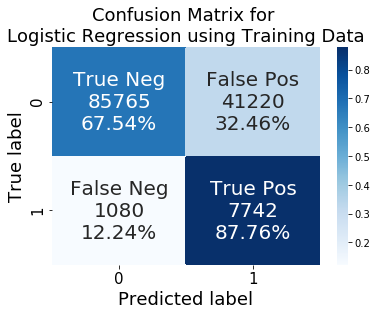

For the Validation Data using Logistic Regression, the accuracy is 0.6881, the precision is 0.1583, the recall is 0.8810, the specificity is 0.6747, the f1 score is 0.2684, the auc is 0.8512
[[12240  5901]
 [  150  1110]]


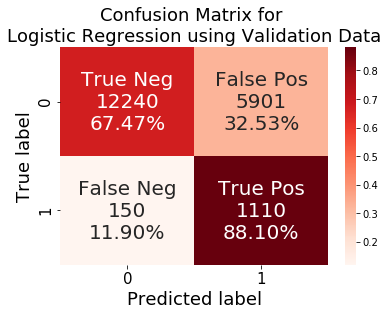

In [27]:
from classifierEvaluation import predictiveValue
from classifierEvaluation import classifierEvaluation

predictiveValue(log_clf, 0.05, X_train, y_train, pipe)
predictiveValue(log_clf, 0.05, X_cv, y_cv, pipe)
predictiveValue(log_clf, 0.05, X_test, y_test, pipe)

classifierEvaluation(log_clf, 0.05, x_train, y_train, "Logistic Regression", "Training Data")
classifierEvaluation(log_clf, 0.05, x_cv, y_cv, "Logistic Regression", "Validation Data")

The key benefit of logistic regression is its interpretability. We can look at the value of the coefficients below:

In [24]:
importance = log_clf.coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -3.05388
Feature: 1, Score: -3.12734
Feature: 2, Score: 13.64817
Feature: 3, Score: 7.72537
Feature: 4, Score: 7.56489
Feature: 5, Score: 0.82776
Feature: 6, Score: 2.68773
Feature: 7, Score: 2.51256
Feature: 8, Score: 1.37194
Feature: 9, Score: 1.03856
Feature: 10, Score: -0.93116
Feature: 11, Score: -14.59890
Feature: 12, Score: -7.21098
Feature: 13, Score: -5.88224
Feature: 14, Score: -1.55488
Feature: 15, Score: -3.06306
Feature: 16, Score: -4.34546
Feature: 17, Score: -1.61943
Feature: 18, Score: -8.82842
Feature: 19, Score: -0.81192
Feature: 20, Score: 0.82776
Feature: 21, Score: -2.56354
Feature: 22, Score: -1.12363
Feature: 23, Score: 0.26591
Feature: 24, Score: -1.19273
Feature: 25, Score: 0.77483
Feature: 26, Score: 0.55607
Feature: 27, Score: -3.87675
Feature: 28, Score: 0.70365
Feature: 29, Score: 0.51560
Feature: 30, Score: -0.06297
Feature: 31, Score: -1.75753
Feature: 32, Score: 1.78696
Feature: 33, Score: 0.79789
Feature: 34, Score: -0.94024
Feature: 

However, this isn't particularly interpretable, so we can get the column names, and then visualize the top 10 parameters

In [25]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(3)
poly.fit_transform(X_train[num_attribs])
cols = poly.get_feature_names(num_attribs)
cols = cols + ['MALE','FEMALE','HEAD', 'TORSO', 'LIMBS']
cols[0] = 'BIAS'

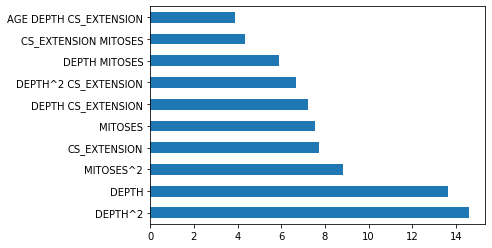

In [26]:
importance = log_clf.coef_[0]
import matplotlib.pyplot as plt
feat_importances = pd.Series(abs(log_clf.coef_[0]), index=cols)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9674, the positive predictive value is 0.0644, the auc is 0.8538
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9684, the positive predictive value is 0.0722, the auc is 0.8524
For the Training Data using Logistic Regression, the accuracy is 0.6888, the precision is 0.1585, the recall is 0.8793, the specificity is 0.6756, the f1 score is 0.2685, the auc is 0.8538
[[85791 41194]
 [ 1065  7757]]


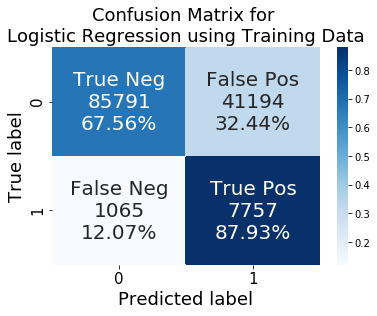

For the Validation Data using Logistic Regression, the accuracy is 0.6895, the precision is 0.1589, the recall is 0.8810, the specificity is 0.6762, the f1 score is 0.2693, the auc is 0.8524
[[12267  5874]
 [  150  1110]]


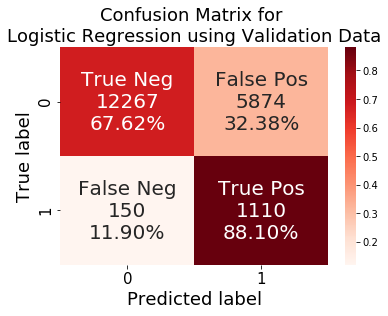

In [11]:
predictiveValue(log_clf, 0.05, X_train, y_train, pipe)
predictiveValue(log_clf, 0.05, X_cv, y_cv, pipe)
#predictiveValue(log_clf, 0.05, X_test, y_test, pipe)

classifierEvaluation(log_clf, 0.05, x_train, y_train, "Logistic Regression", "Training Data")
classifierEvaluation(log_clf, 0.05, x_cv, y_cv, "Logistic Regression", "Validation Data")
#classifierEvaluation(log_clf, 0.05, x_test, y_test, "Logistic Regression", "Test Data")

RESULTS FOR REGULARIZATION 0.05
66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9677, the positive predictive value is 0.0630, the auc is 0.8539
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9681, the positive predictive value is 0.0697, the auc is 0.8524
For the Training Data using Logistic Regression, the accuracy is 0.6862, the precision is 0.1576, the recall is 0.8811, the specificity is 0.6727, the f1 score is 0.2673, the auc is 0.8539
[[85424 41561]
 [ 1049  7773]]


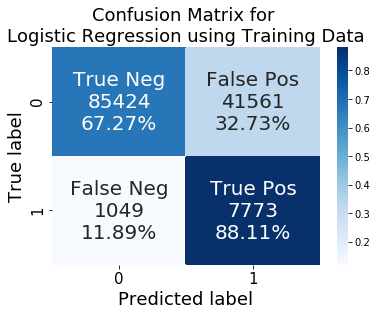

For the Validation Data using Logistic Regression, the accuracy is 0.6861, the precision is 0.1575, the recall is 0.8817, the specificity is 0.6725, the f1 score is 0.2673, the auc is 0.8524
[[12200  5941]
 [  149  1111]]


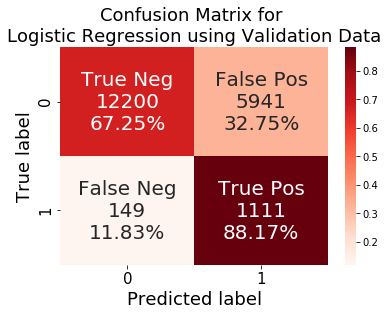





RESULTS FOR REGULARIZATION 0.01
66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9681, the positive predictive value is 0.0616, the auc is 0.8535
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9685, the positive predictive value is 0.0692, the auc is 0.8520
For the Training Data using Logistic Regression, the accuracy is 0.6794, the precision is 0.1552, the recall is 0.8857, the specificity is 0.6651, the f1 score is 0.2641, the auc is 0.8535
[[84452 42533]
 [ 1008  7814]]


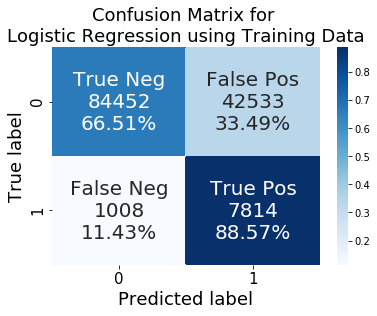

For the Validation Data using Logistic Regression, the accuracy is 0.6789, the precision is 0.1551, the recall is 0.8873, the specificity is 0.6644, the f1 score is 0.2641, the auc is 0.8520
[[12053  6088]
 [  142  1118]]


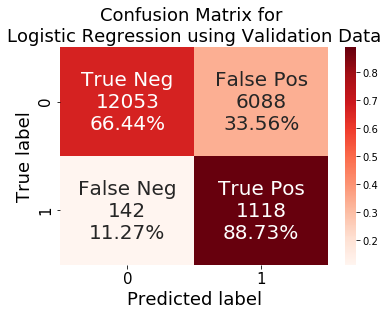





RESULTS FOR REGULARIZATION 0.5
66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9675, the positive predictive value is 0.0638, the auc is 0.8538
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9679, the positive predictive value is 0.0702, the auc is 0.8524
For the Training Data using Logistic Regression, the accuracy is 0.6882, the precision is 0.1583, the recall is 0.8798, the specificity is 0.6749, the f1 score is 0.2683, the auc is 0.8538
[[85704 41281]
 [ 1060  7762]]


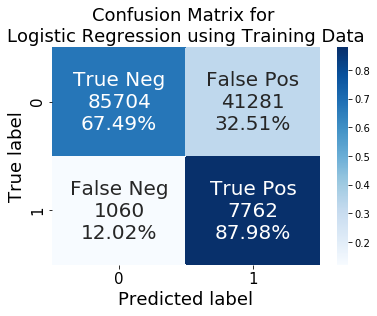

For the Validation Data using Logistic Regression, the accuracy is 0.6886, the precision is 0.1584, the recall is 0.8802, the specificity is 0.6753, the f1 score is 0.2685, the auc is 0.8524
[[12250  5891]
 [  151  1109]]


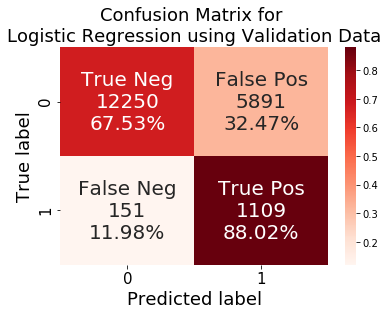





RESULTS FOR REGULARIZATION 1
66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9675, the positive predictive value is 0.0637, the auc is 0.8538
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9679, the positive predictive value is 0.0702, the auc is 0.8524
For the Training Data using Logistic Regression, the accuracy is 0.6884, the precision is 0.1583, the recall is 0.8796, the specificity is 0.6751, the f1 score is 0.2683, the auc is 0.8538
[[85723 41262]
 [ 1062  7760]]


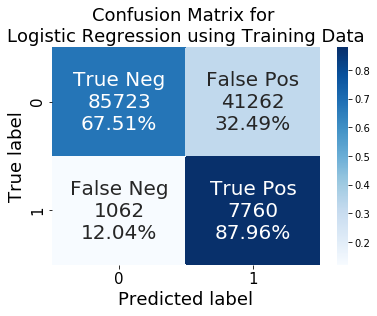

For the Validation Data using Logistic Regression, the accuracy is 0.6886, the precision is 0.1584, the recall is 0.8802, the specificity is 0.6753, the f1 score is 0.2685, the auc is 0.8524
[[12250  5891]
 [  151  1109]]


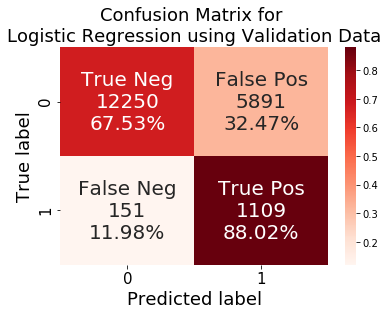





RESULTS FOR REGULARIZATION 5
66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9675, the positive predictive value is 0.0639, the auc is 0.8538
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9679, the positive predictive value is 0.0699, the auc is 0.8524
For the Training Data using Logistic Regression, the accuracy is 0.6885, the precision is 0.1583, the recall is 0.8795, the specificity is 0.6752, the f1 score is 0.2684, the auc is 0.8538
[[85742 41243]
 [ 1063  7759]]


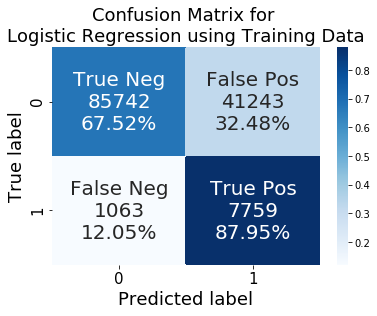

For the Validation Data using Logistic Regression, the accuracy is 0.6886, the precision is 0.1584, the recall is 0.8802, the specificity is 0.6753, the f1 score is 0.2685, the auc is 0.8524
[[12250  5891]
 [  151  1109]]


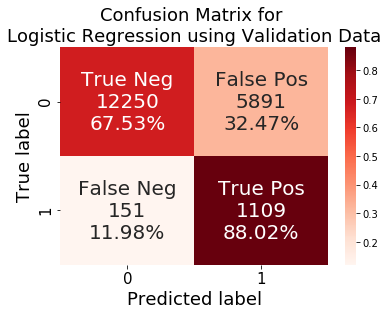





RESULTS FOR REGULARIZATION 10
66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9675, the positive predictive value is 0.0639, the auc is 0.8538
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9679, the positive predictive value is 0.0702, the auc is 0.8524
For the Training Data using Logistic Regression, the accuracy is 0.6885, the precision is 0.1583, the recall is 0.8795, the specificity is 0.6752, the f1 score is 0.2684, the auc is 0.8538
[[85742 41243]
 [ 1063  7759]]


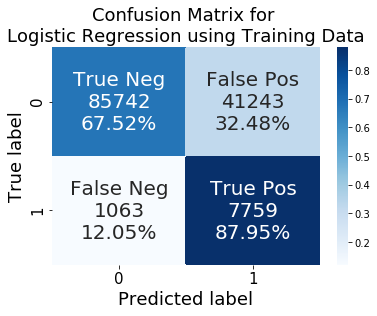

For the Validation Data using Logistic Regression, the accuracy is 0.6886, the precision is 0.1585, the recall is 0.8802, the specificity is 0.6753, the f1 score is 0.2686, the auc is 0.8524
[[12251  5890]
 [  151  1109]]


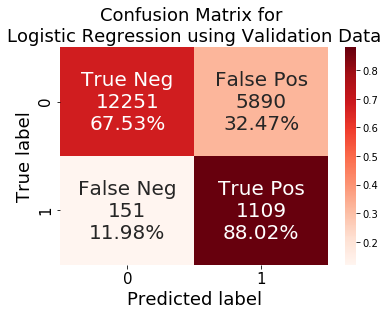





RESULTS FOR REGULARIZATION 50
66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9675, the positive predictive value is 0.0639, the auc is 0.8538
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9679, the positive predictive value is 0.0702, the auc is 0.8524
For the Training Data using Logistic Regression, the accuracy is 0.6885, the precision is 0.1583, the recall is 0.8795, the specificity is 0.6752, the f1 score is 0.2684, the auc is 0.8538
[[85742 41243]
 [ 1063  7759]]


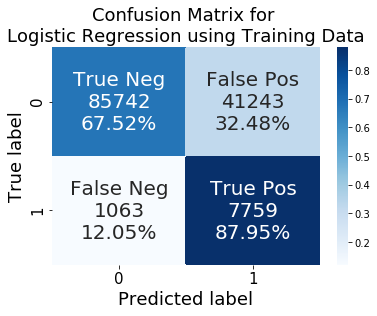

For the Validation Data using Logistic Regression, the accuracy is 0.6886, the precision is 0.1585, the recall is 0.8802, the specificity is 0.6753, the f1 score is 0.2686, the auc is 0.8524
[[12251  5890]
 [  151  1109]]


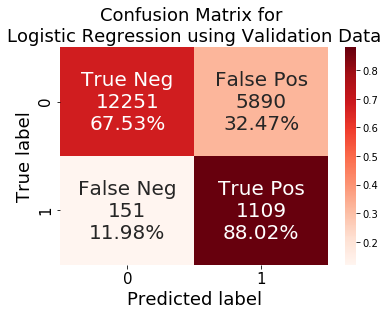

In [15]:
from sklearn.linear_model import LogisticRegression
from classifierEvaluation import classifierEvaluation
from classifierEvaluation import predictiveValue
regularization = [ 0.05, 0.01, 0.5, 1, 5, 10, 50]
for reg in regularization:
    lasso_clf = LogisticRegression(penalty = 'l1',solver="saga", max_iter= 5000,fit_intercept=False, n_jobs = 6, C = reg)
    lasso_clf.fit(x_train,y_train)
    print(f"RESULTS FOR REGULARIZATION {reg}")
    predictiveValue(lasso_clf, 0.05, X_train, y_train, pipe)
    predictiveValue(lasso_clf, 0.05, X_cv, y_cv, pipe)
    #predictiveValue(log_clf, 0.05, X_test, y_test, pipe)

    classifierEvaluation(lasso_clf, 0.05, x_train, y_train, "Logistic Regression", "Training Data")
    classifierEvaluation(lasso_clf, 0.05, x_cv, y_cv, "Logistic Regression", "Validation Data")
    print("\n\n\n")

In [16]:
lasso_clf = LogisticRegression(penalty = 'l1',solver="saga", max_iter= 5000,fit_intercept=False, n_jobs = 6, C = 0.01)
lasso_clf.fit(x_train,y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=6, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

Feature: 0, Score: -2.55155
Feature: 1, Score: -0.35727
Feature: 2, Score: 1.42660
Feature: 3, Score: 0.54895
Feature: 4, Score: 0.68846
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.11336
Feature: 7, Score: -0.00848
Feature: 8, Score: -0.00662
Feature: 9, Score: -0.02847
Feature: 10, Score: 0.00000
Feature: 11, Score: -0.36464
Feature: 12, Score: -0.28524
Feature: 13, Score: -0.18368
Feature: 14, Score: -0.07848
Feature: 15, Score: -0.07832
Feature: 16, Score: -0.03439
Feature: 17, Score: 0.00000
Feature: 18, Score: -0.32291
Feature: 19, Score: -0.07774
Feature: 20, Score: 0.00000
Feature: 21, Score: -0.03944
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: -0.00001
Feature: 25, Score: 0.00025
Feature: 26, Score: 0.00611
Feature: 27, Score: -0.00147
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00251
Feature: 30, Score: 0.00049
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.01217
Feature: 33, Score: 0.00000
Feature: 34, Score: -0.00307
Feature: 35,

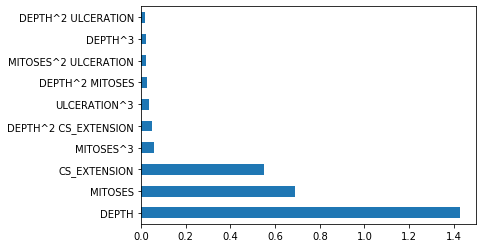

In [17]:
importance = lasso_clf.coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
feat_importances = pd.Series(lasso_clf.coef_[0], index=cols)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

66922
68885
135807
For the THRESHOLD 0.05, the negative predictive value is 0.9681, the positive predictive value is 0.0616, the auc is 0.8535
9552
9849
19401
For the THRESHOLD 0.05, the negative predictive value is 0.9685, the positive predictive value is 0.0692, the auc is 0.8520
19145
19657
38802


/Users/karenlarson/Desktop/MelaSentinel/MelanomaSentinel/classifierEvaluation.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['TARGET'] = y_data


For the THRESHOLD 0.05, the negative predictive value is 0.9649, the positive predictive value is 0.0519, the auc is 0.8463
For the Training Data using Lasso Regression, the accuracy is 0.6794, the precision is 0.1552, the recall is 0.8857, the specificity is 0.6651, the f1 score is 0.2641, the auc is 0.8535
[[84452 42533]
 [ 1008  7814]]


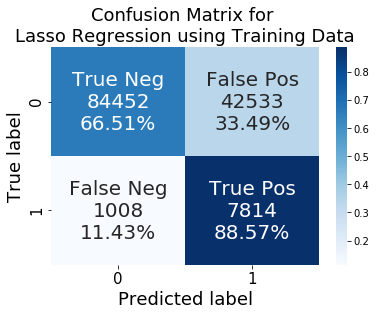

For the Validation Data using Lasso Regression, the accuracy is 0.6789, the precision is 0.1551, the recall is 0.8873, the specificity is 0.6644, the f1 score is 0.2641, the auc is 0.8520
[[12053  6088]
 [  142  1118]]


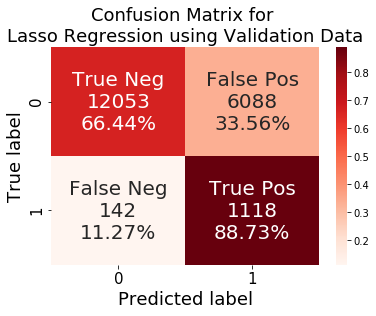

For the Test Data using Logistic Regression, the accuracy is 0.6854, the precision is 0.1554, the recall is 0.8663, the specificity is 0.6728, the f1 score is 0.2635, the auc is 0.8463
[[24410 11871]
 [  337  2184]]


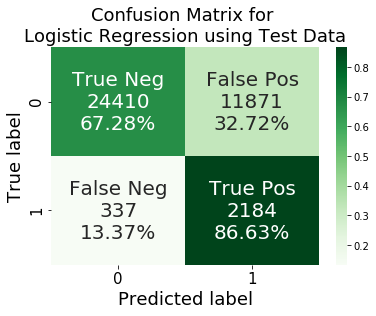

In [18]:
predictiveValue(lasso_clf, 0.05, X_train, y_train, pipe)
predictiveValue(lasso_clf, 0.05, X_cv, y_cv, pipe)

classifierEvaluation(lasso_clf, 0.05, x_train, y_train, "Lasso Regression", "Training Data")
classifierEvaluation(lasso_clf, 0.05, x_cv, y_cv, "Lasso Regression", "Validation Data")


# Splitting on strata

In [78]:
from splitStrata import splitStrata

T1a, y1a, T1b, y1b, T2a, y2a, T2b, y2b, T3a, y3a, T3b, y3b, T4a, y4a, T4b, y4b = splitStrata(X_test, y_test)

/Users/karenlarson/Desktop/MelaSentinel/MelanomaSentinel/splitStrata.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['TARGET'] = y_data


In [79]:
x_t1a = pipe.transform(T1a)
x_t1b = pipe.transform(T1b)

x_t2a = pipe.transform(T2a)
x_t2b = pipe.transform(T2b)

x_t3a = pipe.transform(T3a)
x_t3b = pipe.transform(T3b)

x_t4a = pipe.transform(T4a)
x_t4b = pipe.transform(T4b)

For the T1a Val Data using Random Forest, the accuracy is 0.9910, the precision is 0.0986, the recall is 0.0761, the specificity is 0.9961, the f1 score is 0.0859, the auc is 0.7732
[[16334    64]
 [   85     7]]


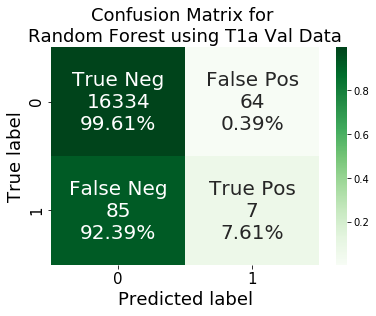

For the T1b Val Data using Random Forest, the accuracy is 0.7700, the precision is 0.0921, the recall is 0.6014, the specificity is 0.7763, the f1 score is 0.1597, the auc is 0.7765
[[5682 1637]
 [ 110  166]]


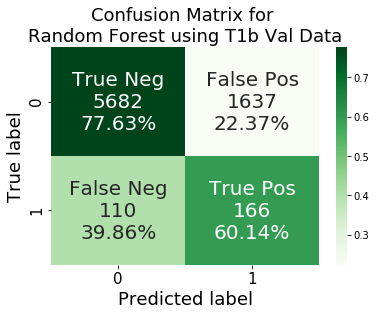

For the T2a Val Data using Random Forest, the accuracy is 0.3090, the precision is 0.1121, the recall is 0.9196, the specificity is 0.2458, the f1 score is 0.1999, the auc is 0.6934
[[1329 4078]
 [  45  515]]


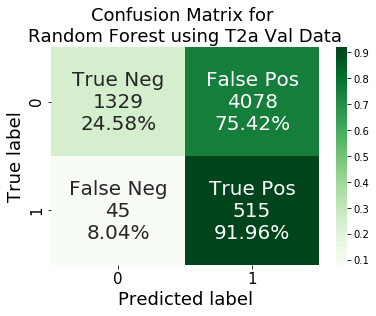

For the T2b Val Data using Random Forest, the accuracy is 0.2825, the precision is 0.1414, the recall is 0.9483, the specificity is 0.1887, the f1 score is 0.2461, the auc is 0.6775
[[ 233 1002]
 [   9  165]]


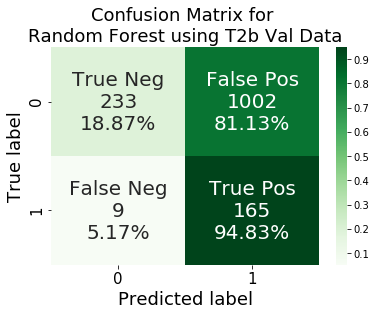

For the T3a Val Data using Random Forest, the accuracy is 0.2087, the precision is 0.1761, the recall is 0.9953, the specificity is 0.0478, the f1 score is 0.2992, the auc is 0.6946
[[  99 1970]
 [   2  421]]


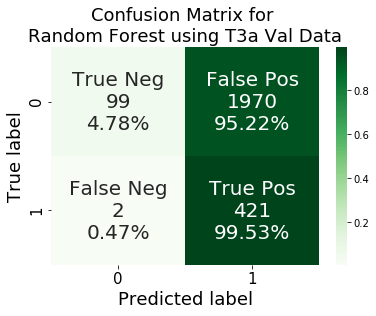

For the T3b Val Data using Random Forest, the accuracy is 0.2121, the precision is 0.1997, the recall is 0.9973, the specificity is 0.0194, the f1 score is 0.3327, the auc is 0.6837
[[  29 1463]
 [   1  365]]


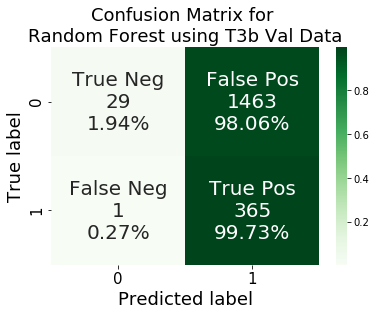

For the T4a Val Data using Random Forest, the accuracy is 0.2416, the precision is 0.2407, the recall is 1.0000, the specificity is 0.0015, the f1 score is 0.3880, the auc is 0.6784
[[   2 1306]
 [   0  414]]


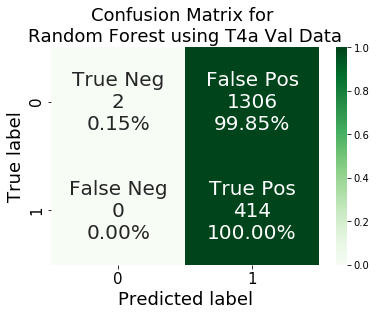

For the T4b Val Data using Random Forest, the accuracy is 0.1765, the precision is 0.1713, the recall is 1.0000, the specificity is 0.0076, the f1 score is 0.2925, the auc is 0.6699
[[   8 1045]
 [   0  216]]


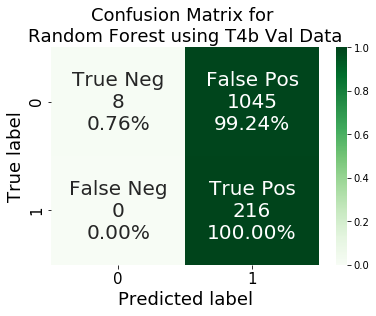

In [80]:
thresh = 0.05

classifierEvaluation(forest, 0.05, x_t1a, y1a, "Random Forest", "T1a Val Data")
classifierEvaluation(forest, 0.05, x_t1b, y1b, "Random Forest", "T1b Val Data")

classifierEvaluation(forest, 0.05, x_t2a, y2a, "Random Forest", "T2a Val Data")
classifierEvaluation(forest, 0.05, x_t2b, y2b, "Random Forest", "T2b Val Data")

classifierEvaluation(forest, 0.05, x_t3a, y3a, "Random Forest", "T3a Val Data")
classifierEvaluation(forest, 0.05, x_t3b, y3b, "Random Forest", "T3b Val Data")

classifierEvaluation(forest, 0.05, x_t4a, y4a, "Random Forest", "T4a Val Data")
classifierEvaluation(forest, 0.05, x_t4b, y4b, "Random Forest", "T4b Val Data")

In [31]:
from splitStrata import splitStrata
T1a, y1a, T1b, y1b, T2a, y2a, T2b, y2b, T3a, y3a, T3b, y3b, T4a, y4a, T4b, y4b = splitStrata(X_test, y_test)
x_t1a = pipe.transform(T1a)
x_t1b = pipe.transform(T1b)

x_t2a = pipe.transform(T2a)
x_t2b = pipe.transform(T2b)

x_t3a = pipe.transform(T3a)
x_t3b = pipe.transform(T3b)

x_t4a = pipe.transform(T4a)
x_t4b = pipe.transform(T4b)

/Users/karenlarson/Desktop/MelaSentinel/MelanomaSentinel/splitStrata.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['TARGET'] = y_data


For the T1a Training Data using Random log_clf, the accuracy is 0.9890, the precision is 0.0505, the recall is 0.0543, the specificity is 0.9943, the f1 score is 0.0524, the auc is 0.7449
[[16304    94]
 [   87     5]]


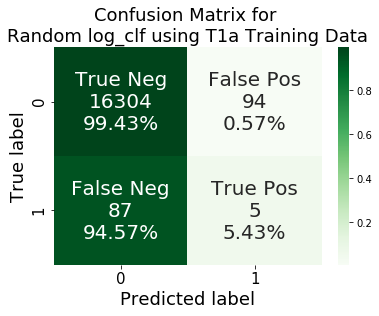

For the T1b Training Data using Random log_clf, the accuracy is 0.7402, the precision is 0.0777, the recall is 0.5652, the specificity is 0.7468, the f1 score is 0.1365, the auc is 0.7350
[[5466 1853]
 [ 120  156]]


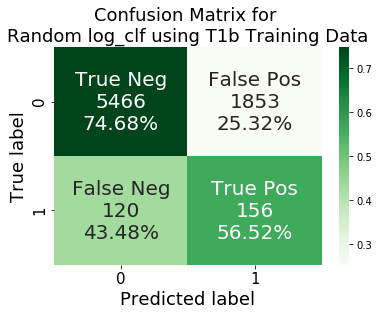

For the T2a Training Data using Random log_clf, the accuracy is 0.4518, the precision is 0.1250, the recall is 0.8071, the specificity is 0.4150, the f1 score is 0.2165, the auc is 0.6679
[[2244 3163]
 [ 108  452]]


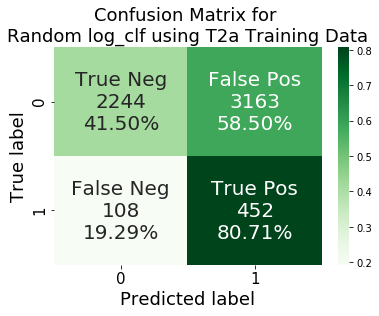

For the T2b Training Data using Random log_clf, the accuracy is 0.2342, the precision is 0.1348, the recall is 0.9598, the specificity is 0.1320, the f1 score is 0.2364, the auc is 0.6507
[[ 163 1072]
 [   7  167]]


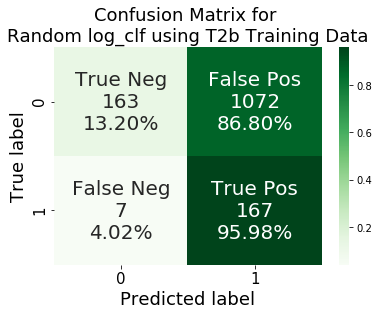

For the T3a Training Data using Random log_clf, the accuracy is 0.2303, the precision is 0.1785, the recall is 0.9811, the specificity is 0.0768, the f1 score is 0.3020, the auc is 0.6717
[[ 159 1910]
 [   8  415]]


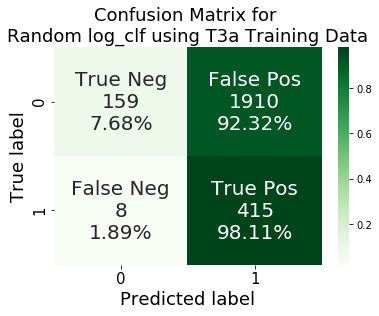

For the T3b Training Data using Random log_clf, the accuracy is 0.2067, the precision is 0.1989, the recall is 1.0000, the specificity is 0.0121, the f1 score is 0.3318, the auc is 0.6721
[[  18 1474]
 [   0  366]]


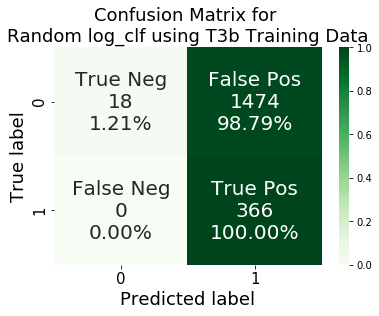

For the T4a Training Data using Random log_clf, the accuracy is 0.2416, the precision is 0.2407, the recall is 1.0000, the specificity is 0.0015, the f1 score is 0.3880, the auc is 0.6603
[[   2 1306]
 [   0  414]]


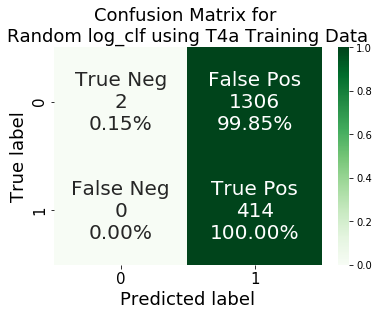

For the T4b Training Data using Random log_clf, the accuracy is 0.2112, the precision is 0.1764, the recall is 0.9907, the specificity is 0.0513, the f1 score is 0.2995, the auc is 0.6339
[[ 54 999]
 [  2 214]]


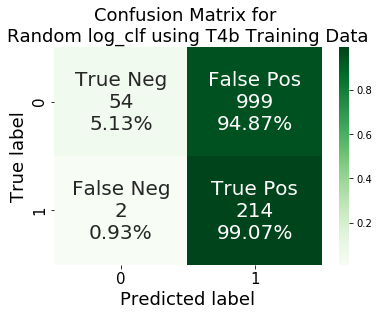

In [32]:
thresh = 0.05

classifierEvaluation(log_clf, 0.05, x_t1a, y1a, "Random log_clf", "T1a Training Data")
classifierEvaluation(log_clf, 0.05, x_t1b, y1b, "Random log_clf", "T1b Training Data")

classifierEvaluation(log_clf, 0.05, x_t2a, y2a, "Random log_clf", "T2a Training Data")
classifierEvaluation(log_clf, 0.05, x_t2b, y2b, "Random log_clf", "T2b Training Data")

classifierEvaluation(log_clf, 0.05, x_t3a, y3a, "Random log_clf", "T3a Training Data")
classifierEvaluation(log_clf, 0.05, x_t3b, y3b, "Random log_clf", "T3b Training Data")

classifierEvaluation(log_clf, 0.05, x_t4a, y4a, "Random log_clf", "T4a Training Data")
classifierEvaluation(log_clf, 0.05, x_t4b, y4b, "Random log_clf", "T4b Training Data")

In [ ]:
#T1a, y1a, T1b, y1b, T2a, y2a, T2b, y2b, T3a, y3a, T3b, y3b, T4a, y4a, T4b, y4b = splitStrata(X_test, y_test)
#x_t1a = pipe.transform(T1a)
#x_t1b = pipe.transform(T1b)
#
#x_t2a = pipe.transform(T2a)
#x_t2b = pipe.transform(T2b)
#
#x_t3a = pipe.transform(T3a)
#x_t3b = pipe.transform(T3b)
#
#x_t4a = pipe.transform(T4a)
#x_t4b = pipe.transform(T4b)

In [ ]:
#thresh = 0.05
#
#classifierEvaluation(forest, 0.04, x_t1a, y1a, "Random Forest", "T1a Test Data")
#classifierEvaluation(forest, 0.05, x_t1b, y1b, "Random Forest", "T1b Test Data")
#
#classifierEvaluation(forest, 0.15, x_t2a, y2a, "Random Forest", "T2a Test Data")
#classifierEvaluation(forest, 0.15, x_t2b, y2b, "Random Forest", "T2b Test Data")
#
#classifierEvaluation(forest, 0.15, x_t3a, y3a, "Random Forest", "T3a Test Data")
#classifierEvaluation(forest, 0.20, x_t3b, y3b, "Random Forest", "T3b Test Data")
#
#classifierEvaluation(forest, 0.25, x_t4a, y4a, "Random Forest", "T4a Test Data")
#classifierEvaluation(forest, 0.25, x_t4b, y4b, "Random Forest", "T4b Test Data")